In [1]:
import subprocess
import os 

In [4]:
from huggingface_hub import snapshot_download
import cv2 
import dotenv 
dotenv.load_dotenv()
import numpy as np
import gradio as gr
import glob
from inference import inference_frame,inference_frame_serial
from inference import inference_frame_par_ready
from inference import process_frame
import os
import pathlib
import multiprocessing as mp
from time import time


REPO_ID='SharkSpace/videos_examples'
snapshot_download(repo_id=REPO_ID, token=os.environ.get('SHARK_MODEL'),repo_type='dataset',local_dir='videos_example')


Fetching 21 files:   0%|          | 0/21 [00:00<?, ?it/s]

'/home/afengler/proj_shark/huggingface/shark_detection/videos_example'

In [6]:
import torch, torchvision
print("torch version:",torch.__version__, "cuda:",torch.cuda.is_available())

# Check MMDetection installation
import mmdet
import os
import mmcv
import mmengine
from mmdet.apis import init_detector, inference_detector
from mmdet.utils import register_all_modules
from mmdet.registry import VISUALIZERS

from huggingface_hub import hf_hub_download
from huggingface_hub import snapshot_download
from time import time

classes= ['Beach',
 'Sea',
 'Wave',
 'Rock',
 'Breaking wave',
 'Reflection of the sea',
 'Foam',
 'Algae',
 'Vegetation',
 'Watermark',
 'Bird',
 'Ship',
 'Boat',
 'Car',
 'Kayak',
 "Shark's line",
 'Dock',
 'Dog',
 'Unidentifiable shade',
 'Bird shadow',
 'Boat shadow',
 'Kayal shade',
 'Surfer shadow',
 'Shark shadow',
 'Surfboard shadow',
 'Crocodile',
 'Sea cow',
 'Stingray',
 'Person',
 'Ocean',
 'Surfer',
 'Surfer',
 'Fish',
 'Killer whale',
 'Whale',
 'Dolphin',
 'Miscellaneous',
 'Unidentifiable shark',
 'Carpet shark',
 'Dusty shark',
 'Blue shark',
 'Great white shark',
 'Copper shark',
 'Nurse shark',
 'Silky shark',
 'Leopard shark',
 'Shortfin mako shark',
 'Hammerhead shark',
 'Oceanic whitetip shark',
 'Blacktip shark',
 'Tiger shark',
 'Bull shark']*3

class_sizes = {'Beach': None,
               'Sea': None,
               'Wave': None,
               'Rock': None,
               'Breaking wave': None,
               'Reflection of the sea': None,
               'Foam': None,
               'Algae': None,
               'Vegetation': None,
               'Watermark': None,
               'Bird': {'feet':[1, 3], 'meter': [0.3, 0.9], 'kg': [0.5, 1.5], 'pounds': [1, 3]},
               'Ship': {'feet':[10, 100], 'meter': [3, 30], 'kg': [1000, 100000], 'pounds': [2200, 220000]},
               'Boat': {'feet':[10, 45], 'meter': [3, 15], 'kg': [750, 80000], 'pounds': [1500, 160000]},
               'Car': {'feet':[10, 20], 'meter': [3, 6], 'kg': [1000, 2000], 'pounds': [2200, 4400]},
               'Kayak': {'feet':[10, 20], 'meter': [3, 6], 'kg': [50, 300], 'pounds': [100, 600]},
               "Shark's line": None,
               'Dock': None,
               'Dog': {'feet':[1, 3], 'meter': [0.3, 0.9], 'kg': [10, 50], 'pounds': [20, 100]},
               'Unidentifiable shade': None,
               'Bird shadow': None,
               'Boat shadow': None,
               'Kayal shade': None,
               'Surfer shadow': None,
               'Shark shadow': None,
               'Surfboard shadow': None,
               'Crocodile': {'feet':[10, 20], 'meter': [3, 6], 'kg': [410, 1000], 'pounds': [900, 2200]},
               'Sea cow':  {'feet':[9,12], 'meter': [3, 4], 'kg': [400, 590], 'pounds': [900, 1300]},
               'Stingray': {'feet':[2, 7.5], 'meter': [0.6, 2.5], 'kg': [100, 300], 'pounds': [220, 770]},
               'Person': {'feet':[5, 7], 'meter': [1.5, 2.1], 'kg': [50, 150], 'pounds': [110, 300]},
               'Ocean': None,
               'Surfer': {'feet':[5, 7], 'meter': [1.5, 2.1], 'kg': [50, 150], 'pounds': [110, 300]},
               'Surfer': {'feet':[5, 7], 'meter': [1.5, 2.1], 'kg': [50, 150], 'pounds': [110, 300]},
               'Fish':  {'feet':[1, 3], 'meter': [0.3, 0.9], 'kg': [20, 150], 'pounds': [40, 300]},
               'Killer whale': {'feet':[10, 20], 'meter': [3, 6], 'kg': [3600, 5400], 'pounds': [8000, 12000]},
               'Whale': {'feet':[15, 30], 'meter': [4.5, 10], 'kg': [2500, 80000], 'pounds': [55000, 176000]},
               'Dolphin': {'feet':[6.6, 13.1], 'meter': [2, 4], 'kg': [150, 650], 'pounds': [330, 1430]},
               'Miscellaneous': None,
               'Unidentifiable shark': {'feet': [2, 15], 'meter': [0.6, 4.5], 'kg': [50, 1000], 'pounds': [110, 2200]},
               'Carpet shark': {'feet': [4, 10], 'meter': [1.25, 3], 'kg': [50, 1000], 'pounds': [110, 2200]}, # Prob incorrect
               'Dusty shark': {'feet': [9, 14], 'meter': [3, 4.25], 'kg': [160, 180], 'pounds': [350, 400]},
               'Blue shark': {'feet': [7.9, 12.5], 'meter': [2.4, 3], 'kg': [60, 120], 'pounds': [130, 260]}, 
               'Great white shark': {'feet': [13.1, 20], 'meter': [4, 6], 'kg': [680, 1800], 'pounds': [1500, 4000]},
               'Copper shark': {'feet': [7.2, 10.8], 'meter': [2.2, 3.3], 'kg': [130, 300], 'pounds': [290, 660]},
               'Nurse shark': {'feet': [7.9, 9.8], 'meter': [2.4, 3], 'kg': [90, 115], 'pounds': [200, 250]},
               'Silky shark': {'feet': [6.6, 8.2], 'meter': [2, 2.5], 'kg': [300, 380], 'pounds': [660, 840]},
               'Leopard shark': {'feet': [3.9, 4.9], 'meter': [1.2, 1.5], 'kg': [11, 20], 'pounds': [22, 44]},
               'Shortfin mako shark': {'feet': [10.5, 12], 'meter': [3.2, 3.6], 'kg': [60, 135], 'pounds': [130, 300]},
               'Hammerhead shark': {'feet': [4.9, 20], 'meter': [1.5, 6.1], 'kg': [230, 450], 'pounds': [500, 1000]},
               'Oceanic whitetip shark': {'feet': [5.9, 9.8], 'meter': [1.8, 3], 'kg': [36, 170], 'pounds': [80, 375]},
               'Blacktip shark': {'feet': [4.9, 6.6], 'meter': [1.5, 2], 'kg': [40, 100], 'pounds': [90, 220]},
               'Tiger shark': {'feet': [9.8, 18], 'meter': [3, 5.5], 'kg': [385, 635], 'pounds': [850, 1400]},
               'Bull shark': {'feet': [7.9, 11.2], 'meter': [2.4, 3.4], 'kg': [200, 315], 'pounds': [440, 690]},
}

class_sizes_lower = {k.lower(): v for k, v in class_sizes.items()}
   
classes_is_shark = [1 if 'shark' in x.lower() else 0 for x in classes]
classes_is_human = [1 if 'person' or 'surfer' in x.lower() else 0 for x in classes]
classes_is_unknown = [1 if 'unidentifiable' in x.lower() else 0 for x in classes]

classes_is_shark_id = [i for i, x in enumerate(classes_is_shark) if x == 1]
classes_is_human_id = [i for i, x in enumerate(classes_is_human) if x == 1]
classes_is_unknown_id = [i for i, x in enumerate(classes_is_unknown) if x == 1]


REPO_ID = "SharkSpace/maskformer_model"
FILENAME = "mask2former"

snapshot_download(repo_id=REPO_ID, token= os.environ.get('SHARK_MODEL'),local_dir='model/')

# Choose to use a config and initialize the detector
config_file ='model/mask2former_swin-t-p4-w7-224_8xb2-lsj-50e_coco-panoptic/mask2former_swin-t-p4-w7-224_8xb2-lsj-50e_coco-panoptic.py'
#'/content/mmdetection/configs/panoptic_fpn/panoptic-fpn_r50_fpn_ms-3x_coco.py'
# Setup a checkpoint file to load
checkpoint_file ='model/mask2former_swin-t-p4-w7-224_8xb2-lsj-50e_coco-panoptic/checkpoint_v2.pth'
# '/content/drive/MyDrive/Algorithms/weights/shark_panoptic_weights_16_4_23/panoptic-fpn_r50_fpn_ms-3x_coco/epoch_36.pth'

# register all modules in mmdet into the registries
register_all_modules()

# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')  # or device='cuda:0'
model.dataset_meta['palette'] = model.dataset_meta['palette'] + model.dataset_meta['palette'][-23:]
model.dataset_meta['classes'] = classes
print(model.cfg.visualizer)
# init visualizer(run the block only once in jupyter notebook)
visualizer = VISUALIZERS.build(model.cfg.visualizer)
print(dir(visualizer))
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_detector
visualizer.dataset_meta = model.dataset_meta
classes = visualizer.dataset_meta.get('classes', None)
palette = visualizer.dataset_meta.get('palette', None)

print(len(classes))
print(len(palette))

torch version: 2.0.0+cu117 cuda: True


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Loads checkpoint by local backend from path: model/mask2former_swin-t-p4-w7-224_8xb2-lsj-50e_coco-panoptic/checkpoint_v2.pth
{'type': 'DetLocalVisualizer', 'vis_backends': [{'type': 'LocalVisBackend'}], 'name': 'visualizer'}
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_dataset_meta', '_draw_instances', '_draw_panoptic_seg', '_init_manager', '_initialize_fig', '_instance_dict', '_instance_name', '_is_posion_valid', '_vis_backends', 'add_config', 'add_datasample', 'add_graph', 'add_image', 'add_scalar', 'add_scalars', 'alpha', 'ax_save', 'bbox_color', 'check_instance_created', 'close', 'dataset_meta', 'dpi', 'draw_bboxes', 'draw_binary_masks', 'draw_circles', 'draw_featmap', 'draw_lines', 'd

/home/afengler/miniconda3/envs/openmmlab2/lib/python3.8/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmdet.visualization.local_visualizer.DetLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


In [21]:
class_sizes_lower

{'beach': None,
 'sea': None,
 'wave': None,
 'rock': None,
 'breaking wave': None,
 'reflection of the sea': None,
 'foam': None,
 'algae': None,
 'vegetation': None,
 'watermark': None,
 'bird': {'feet': [1, 3],
  'meter': [0.3, 0.9],
  'kg': [0.5, 1.5],
  'pounds': [1, 3]},
 'ship': {'feet': [10, 100],
  'meter': [3, 30],
  'kg': [1000, 100000],
  'pounds': [2200, 220000]},
 'boat': {'feet': [10, 45],
  'meter': [3, 15],
  'kg': [750, 80000],
  'pounds': [1500, 160000]},
 'car': {'feet': [10, 20],
  'meter': [3, 6],
  'kg': [1000, 2000],
  'pounds': [2200, 4400]},
 'kayak': {'feet': [10, 20],
  'meter': [3, 6],
  'kg': [50, 300],
  'pounds': [100, 600]},
 "shark's line": None,
 'dock': None,
 'dog': {'feet': [1, 3],
  'meter': [0.3, 0.9],
  'kg': [10, 50],
  'pounds': [20, 100]},
 'unidentifiable shade': None,
 'bird shadow': None,
 'boat shadow': None,
 'kayal shade': None,
 'surfer shadow': None,
 'shark shadow': None,
 'surfboard shadow': None,
 'crocodile': {'feet': [10, 20],
  

In [ ]:
skip_frames = 7
out_fps = 'auto'
input_video = 'videos_example/421.mp4'

cap = cv2.VideoCapture(input_video)

output_path = "notebook_out_vid.mp4"
if out_fps != 'auto' and type(out_fps) == int:
    fps = int(out_fps)
else:
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    if out_fps == 'auto':
        fps = int(fps / skip_frames)

width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

video = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))


In [ ]:
iterating, frame = cap.read()

In [ ]:
iterating

True

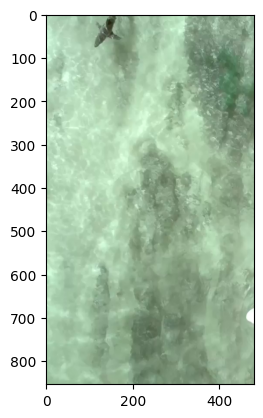

In [ ]:
plt.imshow(frame)

In [ ]:
display_frame = inference_frame_serial(frames[30])

In [ ]:
display_frame

(array([[[239, 237, 231],
         [222, 221, 208],
         [191, 191, 168],
         ...,
         [186, 185, 162],
         [216, 216, 203],
         [236, 235, 229]],
 
        [[239, 237, 231],
         [195, 194, 171],
         [164, 164, 130],
         ...,
         [156, 155, 122],
         [186, 185, 161],
         [236, 235, 229]],
 
        [[239, 237, 231],
         [195, 194, 171],
         [164, 164, 130],
         ...,
         [156, 155, 122],
         [186, 185, 161],
         [236, 235, 229]],
 
        ...,
 
        [[238, 237, 231],
         [223, 222, 210],
         [193, 191, 168],
         ...,
         [192, 189, 167],
         [220, 218, 206],
         [237, 236, 230]],
 
        [[238, 237, 231],
         [238, 237, 231],
         [238, 237, 231],
         ...,
         [238, 237, 231],
         [238, 237, 231],
         [238, 237, 231]],
 
        [[238, 237, 231],
         [238, 237, 231],
         [238, 237, 231],
         ...,
         [238, 237, 231],
  

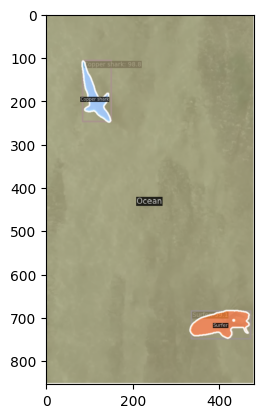

In [ ]:
plt.imshow(display_frame[0])

array([[332., 685., 468., 749.],
       [ 84., 110., 150., 251.]], dtype=float32)

In [ ]:
# 1 x1 (left, lower pixel number)
# 2 y1 (top , lower pixel number)
# 3 x2 (right, higher pixel number)
# 4 y2 (bottom, higher pixel number)

In [ ]:
# 1 x1 (left, lower pixel number)
# 2 y1 (top , lower pixel number)
# 3 x2 (right, higher pixel number)
# 4 y2 (bottom, higher pixel number)
my_bboxes = predictions[30].pred_instances.bboxes[predictions[30].pred_instances.scores.argsort()][::-1][predictions[30].pred_instances.scores[predictions[30].pred_instances.scores.argsort()[::-1]] > 0.5]
my_bboxes

# Size of a box
box_size = np.linalg.norm(my_bboxes[0,[0,1]] - my_bboxes[0, [2,3]])

# Middle of a box
box_middle1 = np.array([(my_bboxes[0, 2] + my_bboxes[0, 0]) / 2, (my_bboxes[0, 3] + my_bboxes[0, 1]) / 2])
box_middle2 = np.array([(my_bboxes[1, 2] + my_bboxes[1, 0]) / 2, (my_bboxes[1, 3] + my_bboxes[1, 1]) / 2])
distance = np.linalg.norm(box_middle1 - box_middle2)
print(box_middle1)
print(box_middle2)
print(distance)

# Distance ratio
distance / box_size

[400. 717.]
[117.  180.5]
606.5651242859253


In [ ]:
distance / box_size

4.035525587766196

In [ ]:
my_bboxes[0, [2,3]]

array([468., 749.], dtype=float32)

In [8]:
from matplotlib import pyplot as plt
def process_video(input_video, out_fps = 'auto', skip_frames = 7):
    cap = cv2.VideoCapture(input_video)

    output_path = "notebook_out_vid.mp4"
    if out_fps != 'auto' and type(out_fps) == int:
        fps = int(out_fps)
    else:
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        if out_fps == 'auto':
            fps = int(fps / skip_frames)
    print(fps)
    #width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    #height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # video = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))
    results = []
    frames = []
    iterating, frame = cap.read()
    cnt = 0
    print('starting video processing')
    while iterating:
        if (cnt % skip_frames) == 0:
            #print('cnt')
            # flip frame vertically
            _ , result = inference_frame_serial(frame, visualize = False)
            # Extract information from results
            results.append(result.numpy())
            frames.append(frame)
            # Add extra plot that is result related

            # video.write(cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB))
            # yield cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB), cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), None
            # return result.numpy(), frame
        cnt += 1
        iterating, frame = cap.read()
    
    # video.release()
    return results, frames

In [9]:
import inference
def get_visualization_from_frame(frame, result):
    # flip frame vertically
    #display_frame = inference.visualizer.draw_result(frame, result)
    # Extract information from results

    inference.visualizer.add_datasample(
            'result',
            frame,
            data_sample=result,
            draw_gt = None,
            show=False
            )
    display_frame = visualizer.get_image()

    display_frame = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)
    return display_frame

In [10]:
predictions, frames = process_video('videos_example/421.mp4')

4
starting video processing


/home/afengler/miniconda3/envs/openmmlab2/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
predictions[0].pred_instances.labels[predictions[0].pred_instances.scores.argsort()][::-1][predictions[0].pred_instances.scores[predictions[0].pred_instances.scores.argsort()[::-1]] > 0.5]
#predictions[0].pred_instances.scores[predictions[0].pred_instances.scores.argsort()[::-1]] > 0.5

array([42])

In [52]:
def get_top_predictions(prediction = None, threshold = 0.7):
    if prediction is None:
        return None, None
    else:
        sorted_scores_ids = prediction.pred_instances.scores.argsort()[::-1]
        sorted_scores = prediction.pred_instances.scores[sorted_scores_ids]
        sorted_predictions = prediction.pred_instances.labels[sorted_scores_ids]
        return {'pred_above_thresh': sorted_predictions[sorted_scores > threshold], 
                'pred_above_thresh_id': sorted_scores_ids[sorted_scores > threshold],
                'pred_above_thresh_scores': sorted_scores[sorted_scores > threshold],
                'pred_above_thresh_bboxes': prediction.pred_instances['bboxes'][sorted_scores_ids][sorted_scores > threshold]}
    
def add_class_labels(top_pred = {}, class_labels = None):
    if class_labels == None:
        print('No class labels provided, returning original dictionary')
        return top_pred
    else:
        top_pred['pred_above_thresh_labels'] = [class_labels[x].lower() for x in top_pred['pred_above_thresh']]
        top_pred['any_detection'] = len(top_pred['pred_above_thresh_labels']) > 0
        if top_pred['any_detection']:
            # Get shark / human / unknown vectors
            top_pred['is_shark'] = np.array([1 if 'shark' in x else 0 for x in top_pred['pred_above_thresh_labels']])
            top_pred['is_human'] = np.array([1 if 'person' in x else 1 if 'surfer' in x else 0 for x in top_pred['pred_above_thresh_labels']])
            top_pred['is_unknown'] = np.array([1 if 'unidentifiable' in x else 0 for x in top_pred['pred_above_thresh_labels']])
            # Get shark / human / unknown  numbers of detections
            top_pred['shark_n'] = np.sum(top_pred['is_shark'])
            top_pred['human_n'] = np.sum(top_pred['is_human'])
            top_pred['unknown_n'] = np.sum(top_pred['is_unknown'])
        return top_pred

def add_class_sizes(top_pred = {}, class_sizes = None):
    size_list = []
    if top_pred['any_detection']:
        for tmp_pred in top_pred['pred_above_thresh_labels']:
                tmp_class_sizes = class_sizes[tmp_pred.lower()]
                if tmp_class_sizes == None:
                    size_list.append(None)
                else:
                    size_list.append(tmp_class_sizes['feet'])

        top_pred['pred_above_thresh_sizes'] = size_list
    else:
        top_pred['pred_above_thresh_sizes'] = None
    return top_pred

def add_class_weights(top_pred = {}, class_weights = None):
    size_list = []
    if top_pred['any_detection']:
        for tmp_pred in top_pred['pred_above_thresh_labels']:
                tmp_class_weights = class_weights[tmp_pred.lower()]
                if tmp_class_weights == None:
                    size_list.append(None)
                else:
                    size_list.append(tmp_class_weights['pounds'])

        top_pred['pred_above_thresh_weights'] = size_list
    else:
        top_pred['pred_above_thresh_weights'] = None
    return top_pred

# Sizes
def get_min_distance_shark_person(top_pred, class_sizes = None, dangerous_distance = 100):
    min_dist = 99999
    dist_calculated = False
    # Calculate distance for every pairing of human and shark
    # and accumulate the min distance
    for i, tmp_shark in enumerate(top_pred['is_shark']):
        for j, tmp_person in enumerate(top_pred['is_human']):
            if tmp_shark == 1 and tmp_person == 1:
                dist_calculated = True
                print(top_pred['pred_above_thresh_bboxes'][i])
                print(top_pred['pred_above_thresh_bboxes'][j])
                tmp_dist_feed = _calculate_dist_estimate(top_pred['pred_above_thresh_bboxes'][i], 
                                                         top_pred['pred_above_thresh_bboxes'][j], 
                                                         [top_pred['pred_above_thresh_labels'][i], top_pred['pred_above_thresh_labels'][j]],
                                                         class_sizes,
                                                         measurement = 'feet')
                print(tmp_dist_feed)
                min_dist = min(min_dist, tmp_dist_feed)
            else:
                pass
    return {'min_dist': str(round(min_dist,1)) + ' feet', 
            'any_dist_calculated': dist_calculated, 
            'dangerous_dist': min_dist < dangerous_distance}

def _calculate_dist_estimate(bbox1, bbox2, labels, class_sizes = None, measurement = 'feet'):
    class_feet_size_mean = np.array([class_sizes[labels[0]][measurement][0], 
                                     class_sizes[labels[1]][measurement][0]]).mean()
    box_pixel_size_mean = np.array([np.linalg.norm(bbox1[[0, 1]] - bbox1[[2, 3]]), 
                                    np.linalg.norm(bbox2[[0, 1]] - bbox2[[2, 3]])]).mean()
    
    # Calculate the max size of the two boxes
    box_center_1 = np.array([(bbox1[2] - bbox1[0])/2 + bbox1[0], 
                             (bbox1[3] - bbox1[1])/2 + bbox1[1]])
    box_center_2 = np.array([(bbox2[2] - bbox2[0])/2 + bbox2[0], 
                             (bbox2[3] - bbox2[1])/2 + bbox2[1]])
    
    # Return ratio distance
    return np.linalg.norm(box_center_1 - box_center_2) / box_pixel_size_mean * class_feet_size_mean

# bboxes info!
# 1 x1 (left, lower pixel number)
# 2 y1 (top , lower pixel number)
# 3 x2 (right, higher pixel number)
# 4 y2 (bottom, higher pixel number)

In [54]:
top_pred = get_top_predictions(predictions[30], threshold = 0.5)
top_pred = add_class_labels(top_pred, class_labels = classes)
top_pred = add_class_sizes(top_pred, class_sizes = class_sizes_lower)
top_pred = add_class_weights(top_pred, class_weights = class_sizes_lower)
min_dist = get_min_distance_shark_person(top_pred, class_sizes = class_sizes_lower)


[ 84. 110. 150. 251.]
[332. 685. 468. 749.]
24.184207818187375


In [44]:
top_pred

{'pred_above_thresh': array([31, 42]),
 'pred_above_thresh_id': array([21,  2]),
 'pred_above_thresh_scores': array([0.9908303 , 0.98758847], dtype=float32),
 'pred_above_thresh_bboxes': array([[332., 685., 468., 749.],
        [ 84., 110., 150., 251.]], dtype=float32),
 'pred_above_thresh_labels': ['surfer', 'copper shark'],
 'any_detection': True,
 'is_shark': array([0, 1]),
 'is_human': array([1, 0]),
 'is_unknown': array([0, 0]),
 'shark_n': 1,
 'human_n': 1,
 'unknown_n': 0,
 'pred_above_thresh_sizes': [[5, 7], [7.2, 10.8]],
 'pred_above_thresh_weights': [[110, 300], [290, 660]]}

In [ ]:
from time import time
start = time()
out = get_top_predictions(predictions[0], threshold = 0.5)
print(time() - start)

0.0003097057342529297


In [ ]:
out_w_classes = add_class_labels(top_k_pred = out, class_labels = classes)

In [ ]:
out_w_classes

{'pred_above_thresh': array([42]),
 'pred_above_thresh_id': array([7]),
 'pred_above_thresh_scores': array([0.98792475], dtype=float32),
 'pred_above_thresh_bboxes': array([[0., 0., 0., 0.]], dtype=float32),
 'pred_above_thresh_labels': ['Copper shark']}

In [ ]:
sorted_scores_ids = predictions[0].pred_instances.scores.argsort()[::-1]

In [ ]:
sorted_scores_ids

array([ 7, 31, 63, 74, 38, 71, 72, 62, 97, 50, 32, 75, 76, 92, 70, 91, 98,
       64, 55, 37, 73, 54, 49, 99, 65, 89, 90, 26, 20, 21, 22, 23, 24, 25,
       77, 18, 27, 28, 29, 30, 95, 94, 33, 19, 17, 35, 16,  1,  2,  3,  4,
        5,  6, 96,  8,  9, 10, 11, 12, 13, 14, 15, 34, 93, 36, 78, 58, 59,
       60, 61, 85, 84, 83, 66, 67, 68, 69, 82, 81, 80, 79, 57, 56, 86, 45,
       39, 40, 41, 42, 43, 44, 46, 87, 47, 48, 88, 51, 52, 53,  0])

In [ ]:
predictions[0].pred_instances['bboxes'][sorted_scores_ids]

array([[110.,   0., 177.,  78.],
       [  0., 439.,   2., 450.],
       [  0., 439.,   2., 450.],
       [  0., 439.,   1., 443.],
       [  0., 440.,   1., 443.],
       [  0., 439.,   1., 443.],
       [  0., 439.,   1., 443.],
       [  0., 439.,   2., 450.],
       [  0., 439.,   2., 450.],
       [  0., 439.,   2., 450.],
       [  0., 439.,   2., 450.],
       [  0., 440.,   1., 443.],
       [  0., 440.,   1., 443.],
       [  0., 440.,   1., 443.],
       [  0., 439.,   1., 443.],
       [  0., 440.,   1., 443.],
       [  0., 439.,   2., 450.],
       [  0., 439.,   2., 450.],
       [  0., 439.,   2., 450.],
       [  0., 440.,   1., 443.],
       [  0., 439.,   1., 443.],
       [  0., 439.,   2., 450.],
       [  0., 439.,   2., 450.],
       [  0., 440.,   1., 443.],
       [  0., 439.,   2., 443.],
       [  0., 440.,   1., 443.],
       [  0., 440.,   1., 443.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  

In [ ]:
def check_human():
    

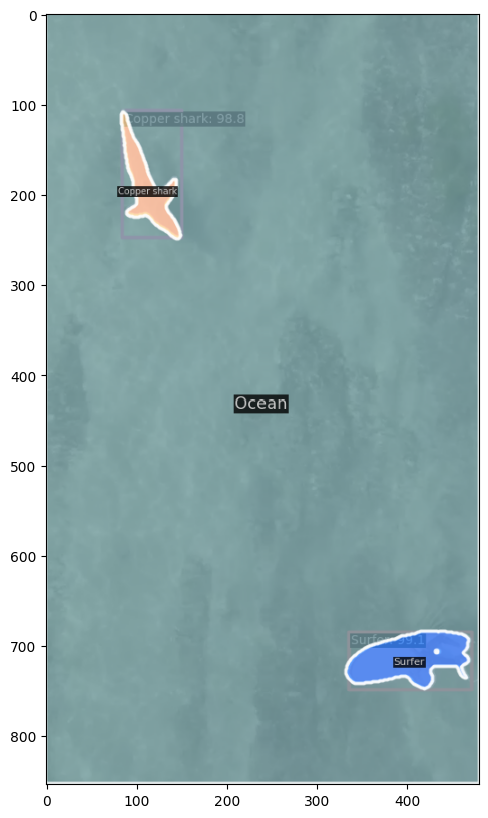

In [37]:
ax, fig = plt.subplots(1,1, figsize=(10,10))
vis_out = get_visualization_from_frame(frames[30], predictions[30])
plt.imshow(vis_out)

In [ ]:
classes.index(19)

ValueError: 19 is not in list

In [ ]:
classes[41]

'Great white shark'

In [ ]:
predictions[0].pred_instances.scores.max()

0.98792475

In [ ]:
pred_id = 30
predictions[pred_id].pred_instances.scores[predictions[pred_id].pred_instances.scores.argsort()]

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e

In [ ]:
predictions[pred_id].pred_instances['bboxes']

array([[  0.,   0.,   0.,   0.],
       [ 84., 110., 150., 251.],
       [ 84., 110., 150., 251.],
       [ 84., 110., 150., 251.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [332., 685., 468., 749.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  

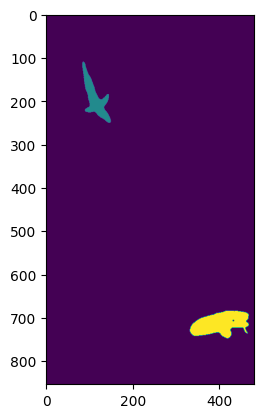

In [36]:
plt.imshow(predictions[30].pred_panoptic_seg.sem_seg.squeeze())

In [ ]:
predictions[0].pred_instances.labels[predictions[0].pred_instances.scores.argsort()]

array([29, 42, 38, 31, 42, 29, 29, 38, 31, 38, 37, 31, 29, 31, 29, 29, 31,
       19, 29, 29, 31, 37, 38, 29, 29, 31, 29, 42, 19, 29, 19, 42, 38, 31,
       31, 31, 29, 31, 29, 24, 23, 19, 18, 17, 15,  4, 31, 42, 38, 31, 29,
       19, 31, 30, 29, 31, 33, 29, 31, 29, 42, 29, 42, 52, 32, 29, 46, 45,
       42, 38, 37, 36, 51, 19, 31, 31, 31, 29, 29, 38, 29, 42, 29, 31, 29,
       19, 31, 31, 29, 42, 31, 29, 29, 31, 29, 31, 42, 31, 19, 42])

In [ ]:
predictions[0].pred_instances.labels[predictions[0].pred_instances.scores.argsort()]

array([29, 42, 38, 31, 42, 29, 29, 38, 31, 38, 37, 31, 29, 31, 29, 29, 31,
       19, 29, 29, 31, 37, 38, 29, 29, 31, 29, 42, 19, 29, 19, 42, 38, 31,
       31, 31, 29, 31, 29, 24, 23, 19, 18, 17, 15,  4, 31, 42, 38, 31, 29,
       19, 31, 30, 29, 31, 33, 29, 31, 29, 42, 29, 42, 52, 32, 29, 46, 45,
       42, 38, 37, 36, 51, 19, 31, 31, 31, 29, 29, 38, 29, 42, 29, 31, 29,
       19, 31, 31, 29, 42, 31, 29, 29, 31, 29, 31, 42, 31, 19, 42])

In [ ]:
predictions, frames = process_video('videos_example/421.mp4')

4
starting video processing
cnt
inference time: 0.12380337715148926
cnt
inference time: 0.11678862571716309
cnt
inference time: 0.11650824546813965
cnt
inference time: 0.11769247055053711
cnt
inference time: 0.11684751510620117
cnt
inference time: 0.1162269115447998
cnt
inference time: 0.11634016036987305
cnt
inference time: 0.1202244758605957
cnt
inference time: 0.1183769702911377
cnt
inference time: 0.1299581527709961
cnt
inference time: 0.11743426322937012
cnt
inference time: 0.12219834327697754
cnt
inference time: 0.11864471435546875
cnt
inference time: 0.11449122428894043
cnt
inference time: 0.11762261390686035
cnt
inference time: 0.11699914932250977
cnt
inference time: 0.12010049819946289
cnt
inference time: 0.12456440925598145
cnt
inference time: 0.11442089080810547
cnt
inference time: 0.11470508575439453
cnt
inference time: 0.12778210639953613
cnt
inference time: 0.11521315574645996
cnt
inference time: 0.11485767364501953
cnt
inference time: 0.12177467346191406
cnt
inference ti

In [ ]:
predictions.numpy().to_dict()

{'img_path': None,
 'batch_input_shape': (1344, 768),
 'ori_shape': (854, 480),
 'scale_factor': (1.5604166666666666, 1.5608899297423888),
 'pad_shape': (1344, 768),
 'img_id': 0,
 'img_shape': (1333, 749),
 'pred_panoptic_seg': {'sem_seg': array([[[133, 133, 133, ..., 133, 133, 133],
          [133, 133, 133, ..., 133, 133, 133],
          [133, 133, 133, ..., 133, 133, 133],
          ...,
          [133, 133, 133, ..., 133, 133, 133],
          [133, 133, 133, ..., 133, 133, 133],
          [133, 133, 133, ..., 133, 133, 133]]], dtype=int32)},
 'pred_instances': {'masks': array([[[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]],
  
         [[False, False, False, ..., False, Fal

In [ ]:
predictions[0].to_dict().keys()

dict_keys(['img_id', 'batch_input_shape', 'img_path', 'pad_shape', 'ori_shape', 'img_shape', 'scale_factor', 'ignored_instances', 'pred_instances', 'gt_instances', 'pred_panoptic_seg'])

In [ ]:
predictions[0][0]

AttributeError: 'dict' object has no attribute 'numpy'

In [ ]:
dir(predictions[0])

['__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_data_fields',
 '_gt_instances',
 '_ignored_instances',
 '_metainfo_fields',
 '_pred_instances',
 '_pred_panoptic_seg',
 'all_items',
 'all_keys',
 'all_values',
 'batch_input_shape',
 'clone',
 'cpu',
 'cuda',
 'detach',
 'get',
 'gt_instances',
 'gt_panoptic_seg',
 'gt_sem_seg',
 'ignored_instances',
 'img_id',
 'img_path',
 'img_shape',
 'items',
 'keys',
 'metainfo',
 'metainfo_items',
 'metainfo_keys',
 'metainfo_values',
 'new',
 'npu',
 'numpy',
 'ori_shape',
 'pad_shape',
 'pop',
 'pred_instances',
 'pred_panoptic_seg',
 'pred_sem_seg',
 'proposals',
 'scale_factor',
 'set_data',


In [ ]:
predictions[0].to_dict()['pred_instances']['labels'][predictions[0].to_dict()['pred_instances']['scores'] > 0.5]

tensor([42], device='cuda:0')

In [ ]:
classes[4]

'Nurse shark'

In [ ]:
predictions[0].to_dict()['pred_panoptic_seg']['sem_seg']

tensor([[[133, 133, 133,  ..., 133, 133, 133],
         [133, 133, 133,  ..., 133, 133, 133],
         [133, 133, 133,  ..., 133, 133, 133],
         ...,
         [133, 133, 133,  ..., 133, 133, 133],
         [133, 133, 133,  ..., 133, 133, 133],
         [133, 133, 133,  ..., 133, 133, 133]]], device='cuda:0',
       dtype=torch.int32)

In [ ]:
process_video('videos_example/421.mp4')

4
True
(854, 480, 3)


In [ ]:
cnt = 0
for x,y,z in process_video('videos_example/421.mp4'):
    print(x)
    print(y)
    print(z)
    cnt += 1
    if cnt > 10:
        break


4
starting video processing
in iteration
inference time: 0.15168356895446777
sending frame
0
[[[231 237 239]
  [208 221 222]
  [168 191 191]
  ...
  [162 185 186]
  [203 216 216]
  [229 235 236]]

 [[231 237 239]
  [171 194 195]
  [130 164 164]
  ...
  [122 155 156]
  [161 185 186]
  [229 235 236]]

 [[231 237 239]
  [171 194 195]
  [130 164 164]
  ...
  [122 155 156]
  [161 185 186]
  [229 235 236]]

 ...

 [[231 237 238]
  [210 222 223]
  [168 191 193]
  ...
  [167 189 192]
  [206 218 220]
  [230 236 237]]

 [[231 237 238]
  [231 237 238]
  [231 237 238]
  ...
  [231 237 238]
  [231 237 238]
  [231 237 238]]

 [[231 237 238]
  [231 237 238]
  [231 237 238]
  ...
  [231 237 238]
  [231 237 238]
  [231 237 238]]]
[[[190 218 183]
  [190 218 183]
  [191 219 184]
  ...
  [146 171 140]
  [146 171 140]
  [146 171 140]]

 [[190 218 183]
  [190 218 183]
  [190 218 183]
  ...
  [149 174 143]
  [150 175 144]
  [150 175 144]]

 [[190 218 183]
  [190 218 183]
  [188 216 181]
  ...
  [153 178 147]

/home/afengler/miniconda3/envs/openmmlab2/lib/python3.8/site-packages/mmengine/visualization/visualizer.py:741: UserWarning: Warning: The bbox is out of bounds, the drawn bbox may not be in the image
  warnings.warn(
/home/afengler/miniconda3/envs/openmmlab2/lib/python3.8/site-packages/mmengine/visualization/visualizer.py:812: UserWarning: Warning: The polygon is out of bounds, the drawn polygon may not be in the image
  warnings.warn(


sending frame
42
[[[231 237 239]
  [209 221 222]
  [170 193 194]
  ...
  [162 185 186]
  [202 215 216]
  [228 235 236]]

 [[231 237 239]
  [173 195 197]
  [134 167 168]
  ...
  [122 155 156]
  [161 184 185]
  [229 235 236]]

 [[231 237 239]
  [173 195 197]
  [134 167 168]
  ...
  [122 155 156]
  [161 185 186]
  [229 235 236]]

 ...

 [[231 237 238]
  [210 222 223]
  [169 192 193]
  ...
  [167 189 191]
  [206 218 219]
  [230 236 237]]

 [[231 237 238]
  [231 237 238]
  [231 237 238]
  ...
  [231 237 238]
  [231 237 238]
  [231 237 238]]

 [[231 237 238]
  [231 237 238]
  [231 237 238]
  ...
  [231 237 238]
  [231 237 238]
  [231 237 238]]]
[[[206 232 198]
  [206 232 198]
  [206 232 198]
  ...
  [143 168 137]
  [144 169 138]
  [150 175 144]]

 [[212 238 204]
  [212 238 204]
  [208 234 200]
  ...
  [143 168 137]
  [144 169 138]
  [150 175 144]]

 [[216 239 206]
  [215 238 205]
  [211 234 201]
  ...
  [143 168 137]
  [144 169 138]
  [150 175 144]]

 ...

 [[166 200 159]
  [166 200 159]
  [

In [ ]:
cap = cv2.VideoCapture(input_video)

    output_path = "notebook_out_vid.mp4"
    if out_fps != 'auto' and type(out_fps) == int:
        fps = int(out_fps)
    else:
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        if out_fps == 'auto':
            fps = int(fps / skip_frames)

    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

    iterating, frame = cap.read()
    cnt = 0
    
    while iterating:
        if (cnt % skip_frames) == 0:
            # flip frame vertically
            display_frame = inference_frame_serial(frame)
            video.write(cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB))
            print('sending frame')
            print(cnt)
            yield cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB), cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), None
        cnt += 1
        iterating, frame = cap.read()